# MLIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Learning Objectives

1. Fit **MLIKH** to LAOS data (nonlinear oscillatory response)
2. Analyze **multi-mode Lissajous figures** and harmonic content
3. Compare nonlinearity from single vs multi-mode models
4. Understand mode interactions in large amplitude deformation

## Prerequisites

- NB06: MIKH LAOS (single-mode understanding)
- NB07: MLIKH Flow Curve (multi-mode basics)

## Runtime

- Fast demo: ~5-6 minutes
- Full run: ~20-25 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from scipy.fft import rfft, rfftfreq

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_pnas_laos,
    save_ikh_results,
    print_convergence_summary,
    compute_fit_quality,
    get_mlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")

JAX version: 0.8.2


## 2. Theory: Multi-Mode LAOS

In MLIKH LAOS, each mode responds independently to the applied strain:

$$
\sigma_{total}(t) = \sum_{i=1}^N \sigma_i(t) + \eta_{\infty} \dot{\gamma}(t)
$$

### Mode Interactions

- Modes yield at different strains
- Different restructuring timescales within cycle
- Complex harmonic content from mode superposition

### Harmonic Enrichment

Multi-mode models can produce:
- Richer higher harmonic content ($I_5/I_1$, $I_7/I_1$)
- More complex Lissajous shapes
- Frequency-dependent nonlinearity

## 3. Load Data

In [3]:
# Load LAOS data
omega = 1.0
strain_amp_idx = 8

t_data, strain_data, stress_data = load_pnas_laos(
    omega=omega,
    strain_amplitude_index=strain_amp_idx
)

gamma_0 = np.max(np.abs(strain_data))
print(f"LAOS data: omega = {omega} rad/s, gamma_0 = {gamma_0:.4f}")
print(f"Points: {len(t_data)}")

LAOS data: omega = 1.0 rad/s, gamma_0 = 3.1599
Points: 1000


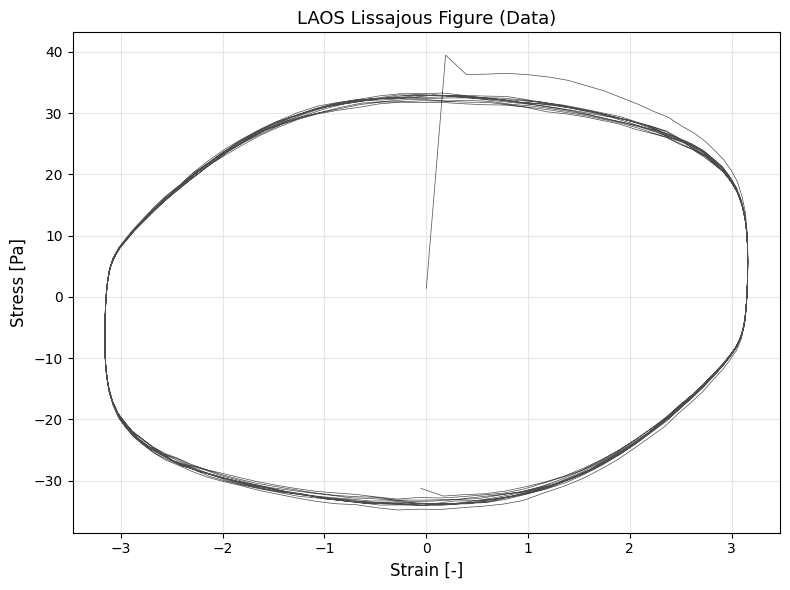

In [4]:
# Plot Lissajous
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(strain_data, stress_data, "k-", lw=0.5, alpha=0.7)
ax.set_xlabel("Strain [-]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("LAOS Lissajous Figure (Data)", fontsize=13)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit MLIKH model
n_modes = 2
model = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

print(f"Fitting MLIKH ({n_modes} modes) to LAOS")
t0 = time.time()
model.fit(t_data, stress_data, test_mode="laos", gamma_0=gamma_0, omega=omega, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")

Fitting MLIKH (2 modes) to LAOS


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/ml_ikh.py", line 616, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 2.00 s


In [6]:
# Compute fit quality
stress_pred = model.predict(t_data, test_mode="laos",  gamma_0=gamma_0,  omega=omega)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   0.997975
  RMSE:  1.112 Pa


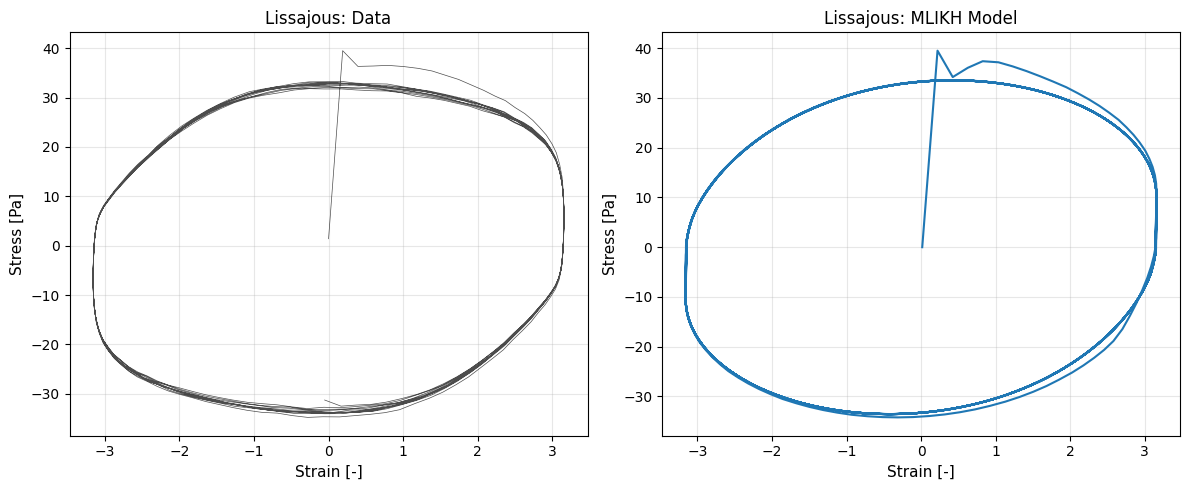

In [7]:
# Compare Lissajous figures
strain_pred = gamma_0 * np.sin(omega * np.array(t_data))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(strain_data, stress_data, "k-", lw=0.5, alpha=0.7)
ax1.set_xlabel("Strain [-]", fontsize=11)
ax1.set_ylabel("Stress [Pa]", fontsize=11)
ax1.set_title("Lissajous: Data", fontsize=12)
ax1.grid(True, alpha=0.3)

ax2.plot(strain_pred, stress_pred, "-", lw=1.5, color="C0")
ax2.set_xlabel("Strain [-]", fontsize=11)
ax2.set_ylabel("Stress [Pa]", fontsize=11)
ax2.set_title("Lissajous: MLIKH Model", fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Harmonic Analysis

In [8]:
# Extract harmonics
def extract_harmonics(t, y, omega, n_harmonics=5):
    n = len(y)
    dt = np.mean(np.diff(t))
    Y = rfft(y)
    freqs = rfftfreq(n, dt)
    f0 = omega / (2 * np.pi)
    idx_f0 = np.argmin(np.abs(freqs - f0))
    
    harmonics = {}
    for h in range(1, n_harmonics + 1):
        idx = idx_f0 * h
        if idx < len(Y):
            harmonics[h] = 2 * np.abs(Y[idx]) / n
        else:
            harmonics[h] = 0.0
    return harmonics

harmonics_data = extract_harmonics(t_data, stress_data, omega)
harmonics_model = extract_harmonics(t_data, np.array(stress_pred), omega)

print("Harmonic Analysis:")
print(f"{'Harmonic':<10} {'Data [Pa]':>12} {'Model [Pa]':>12}")
print("-" * 36)
for h in range(1, 6):
    print(f"  I_{h:<6}    {harmonics_data.get(h, 0):12.3f}   {harmonics_model.get(h, 0):12.3f}")

I3_I1_data = harmonics_data.get(3, 0) / harmonics_data.get(1, 1)
I3_I1_model = harmonics_model.get(3, 0) / harmonics_model.get(1, 1)
print(f"\nThird harmonic ratio I_3/I_1:")
print(f"  Data:  {I3_I1_data:.4f}")
print(f"  Model: {I3_I1_model:.4f}")

Harmonic Analysis:
Harmonic      Data [Pa]   Model [Pa]
------------------------------------
  I_1               23.290         23.222
  I_2                1.421          1.461
  I_3                0.334          0.370
  I_4                0.467          0.505
  I_5                0.593          0.572

Third harmonic ratio I_3/I_1:
  Data:  0.0143
  Model: 0.0159


## 6. Multi-Frequency Comparison

omega = 1.0 rad/s: 1000 points


omega = 3.0 rad/s: 1000 points


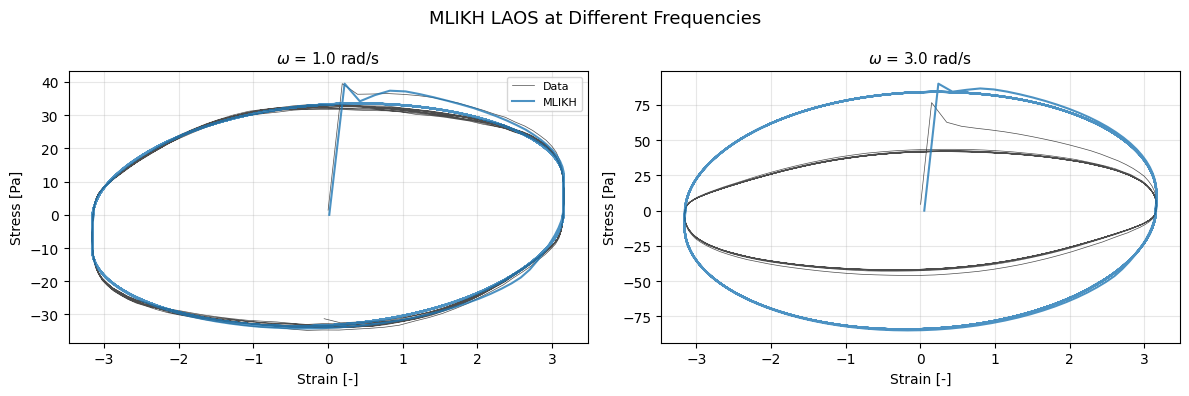

In [9]:
# Load and compare at multiple frequencies (with fallback for missing data)
omega_values = [1.0, 3.0]  # omega=5.0 may not have data at all strain amplitudes
laos_datasets = {}

for w in omega_values:
    try:
        t, strain, stress = load_pnas_laos(omega=w, strain_amplitude_index=strain_amp_idx)
        if len(t) > 0 and len(strain) > 0:
            laos_datasets[w] = {"time": t, "strain": strain, "stress": stress}
            print(f"omega = {w} rad/s: {len(t)} points")
    except Exception as e:
        print(f"omega = {w} rad/s: Failed to load")

n_datasets = len(laos_datasets)
if n_datasets > 0:
    fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 4))
    if n_datasets == 1:
        axes = [axes]

    for i, w in enumerate(laos_datasets.keys()):
        d = laos_datasets[w]
        gamma_0_w = np.max(np.abs(d["strain"]))
        
        # Model prediction
        stress_pred_w = model.predict(d["time"], test_mode="laos", gamma_0=gamma_0_w, omega=w)
        strain_pred_w = gamma_0_w * np.sin(w * np.array(d["time"]))
        
        axes[i].plot(d["strain"], d["stress"], "k-", lw=0.5, alpha=0.7, label="Data")
        axes[i].plot(strain_pred_w, stress_pred_w, "-", lw=1.5, color="C0", alpha=0.8, label="MLIKH")
        axes[i].set_xlabel("Strain [-]", fontsize=10)
        axes[i].set_ylabel("Stress [Pa]", fontsize=10)
        axes[i].set_title(f"$\\omega$ = {w} rad/s", fontsize=11)
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend(fontsize=8)

    plt.suptitle("MLIKH LAOS at Different Frequencies", fontsize=13)
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("No LAOS datasets available for multi-frequency comparison")

## 7. Bayesian Inference

In [10]:
# Bayesian inference (reduced for time-domain LAOS)
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 50   # Reduced for LAOS
NUM_SAMPLES = 100  # Reduced for LAOS
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print("(Note: Time-domain LAOS inference is slow, using reduced samples)")
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="laos",
    gamma_0=gamma_0,
    omega=omega,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)
(Note: Time-domain LAOS inference is slow, using reduced samples)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<01:35,  1.56it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   4%|▍         | 6/150 [00:00<00:17,  8.38it/s, 63 steps of size 1.16e-03. acc. prob=0.50]

warmup:   5%|▌         | 8/150 [00:03<01:17,  1.83it/s, 1023 steps of size 4.89e-04. acc. prob=0.60]

warmup:   6%|▌         | 9/150 [00:06<02:06,  1.11it/s, 1023 steps of size 4.81e-04. acc. prob=0.64]

warmup:   7%|▋         | 10/150 [00:08<02:49,  1.21s/it, 1023 steps of size 4.77e-04. acc. prob=0.68]

warmup:   7%|▋         | 11/150 [00:10<03:22,  1.46s/it, 1023 steps of size 4.75e-04. acc. prob=0.70]

warmup:   8%|▊         | 12/150 [00:12<03:48,  1.66s/it, 1023 steps of size 5.02e-04. acc. prob=0.73]

warmup:   9%|▊         | 13/150 [00:15<04:08,  1.82s/it, 1023 steps of size 5.39e-04. acc. prob=0.75]

warmup:   9%|▉         | 14/150 [00:16<03:42,  1.63s/it, 511 steps of size 5.53e-04. acc. prob=0.77] 

warmup:  10%|█         | 15/150 [00:18<04:08,  1.84s/it, 1023 steps of size 6.06e-04. acc. prob=0.78]

warmup:  11%|█         | 16/150 [00:21<04:26,  1.99s/it, 1023 steps of size 5.84e-04. acc. prob=0.79]

warmup:  11%|█▏        | 17/150 [00:23<04:34,  2.06s/it, 1023 steps of size 6.45e-04. acc. prob=0.80]

warmup:  12%|█▏        | 18/150 [00:25<04:47,  2.18s/it, 1023 steps of size 7.14e-04. acc. prob=0.81]

warmup:  13%|█▎        | 19/150 [00:28<04:52,  2.23s/it, 1023 steps of size 7.91e-04. acc. prob=0.82]

warmup:  13%|█▎        | 20/150 [00:30<04:55,  2.27s/it, 1023 steps of size 8.81e-04. acc. prob=0.83]

warmup:  14%|█▍        | 21/150 [00:32<04:55,  2.29s/it, 1023 steps of size 9.81e-04. acc. prob=0.84]

warmup:  15%|█▍        | 22/150 [00:35<04:55,  2.31s/it, 1023 steps of size 1.09e-03. acc. prob=0.85]

warmup:  15%|█▌        | 23/150 [00:37<04:54,  2.32s/it, 1023 steps of size 1.09e-03. acc. prob=0.85]

warmup:  16%|█▌        | 24/150 [00:39<04:56,  2.35s/it, 1023 steps of size 1.17e-03. acc. prob=0.86]

warmup:  17%|█▋        | 25/150 [00:42<04:59,  2.40s/it, 1023 steps of size 9.51e-04. acc. prob=0.86]

warmup:  17%|█▋        | 26/150 [00:44<04:58,  2.41s/it, 1023 steps of size 8.13e-04. acc. prob=0.86]

warmup:  18%|█▊        | 27/150 [00:47<04:55,  2.41s/it, 1023 steps of size 9.04e-04. acc. prob=0.87]

warmup:  19%|█▊        | 28/150 [00:49<04:58,  2.44s/it, 1023 steps of size 1.01e-03. acc. prob=0.87]

warmup:  19%|█▉        | 29/150 [00:52<04:54,  2.43s/it, 1023 steps of size 1.12e-03. acc. prob=0.88]

warmup:  20%|██        | 30/150 [00:54<04:48,  2.40s/it, 1023 steps of size 1.23e-03. acc. prob=0.88]

warmup:  21%|██        | 31/150 [00:56<04:45,  2.40s/it, 1023 steps of size 1.27e-03. acc. prob=0.88]

warmup:  21%|██▏       | 32/150 [00:59<04:43,  2.40s/it, 1023 steps of size 1.39e-03. acc. prob=0.89]

warmup:  22%|██▏       | 33/150 [01:01<04:41,  2.40s/it, 1023 steps of size 1.37e-03. acc. prob=0.89]

warmup:  23%|██▎       | 34/150 [01:04<04:41,  2.43s/it, 1023 steps of size 1.36e-03. acc. prob=0.89]

warmup:  23%|██▎       | 35/150 [01:06<04:40,  2.44s/it, 1023 steps of size 1.17e-03. acc. prob=0.89]

warmup:  24%|██▍       | 36/150 [01:09<04:36,  2.43s/it, 1023 steps of size 1.28e-03. acc. prob=0.89]

warmup:  25%|██▍       | 37/150 [01:11<04:34,  2.43s/it, 1023 steps of size 1.18e-03. acc. prob=0.90]

warmup:  25%|██▌       | 38/150 [01:13<04:29,  2.41s/it, 1023 steps of size 1.24e-03. acc. prob=0.90]

warmup:  26%|██▌       | 39/150 [01:16<04:27,  2.41s/it, 1023 steps of size 1.26e-03. acc. prob=0.90]

warmup:  27%|██▋       | 40/150 [01:18<04:23,  2.39s/it, 1023 steps of size 1.37e-03. acc. prob=0.90]

warmup:  27%|██▋       | 41/150 [01:21<04:20,  2.39s/it, 1023 steps of size 1.50e-03. acc. prob=0.90]

warmup:  28%|██▊       | 42/150 [01:23<04:16,  2.38s/it, 1023 steps of size 1.63e-03. acc. prob=0.91]

warmup:  29%|██▊       | 43/150 [01:25<04:14,  2.38s/it, 1023 steps of size 1.65e-03. acc. prob=0.91]

warmup:  29%|██▉       | 44/150 [01:28<04:11,  2.37s/it, 1023 steps of size 1.77e-03. acc. prob=0.91]

warmup:  30%|███       | 45/150 [01:30<04:09,  2.38s/it, 1023 steps of size 1.93e-03. acc. prob=0.91]

warmup:  31%|███       | 46/150 [01:32<04:06,  2.37s/it, 1023 steps of size 1.96e-02. acc. prob=0.91]

warmup:  31%|███▏      | 47/150 [01:33<02:59,  1.74s/it, 127 steps of size 1.46e-02. acc. prob=0.91] 

warmup:  32%|███▏      | 48/150 [01:33<02:12,  1.30s/it, 127 steps of size 1.41e-02. acc. prob=0.91]

warmup:  33%|███▎      | 49/150 [01:33<01:49,  1.09s/it, 255 steps of size 1.01e-02. acc. prob=0.91]

warmup:  33%|███▎      | 50/150 [01:34<01:33,  1.08it/s, 255 steps of size 1.22e-02. acc. prob=0.92]

sample:  34%|███▍      | 51/150 [01:35<01:22,  1.20it/s, 255 steps of size 1.22e-02. acc. prob=0.97]

sample:  35%|███▍      | 52/150 [01:36<01:22,  1.19it/s, 383 steps of size 1.22e-02. acc. prob=0.97]

sample:  35%|███▌      | 53/150 [01:36<01:05,  1.49it/s, 127 steps of size 1.22e-02. acc. prob=0.98]

sample:  36%|███▌      | 54/150 [01:36<01:01,  1.55it/s, 255 steps of size 1.22e-02. acc. prob=0.97]

sample:  37%|███▋      | 55/150 [01:37<00:51,  1.85it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  37%|███▋      | 56/150 [01:37<00:43,  2.17it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  38%|███▊      | 57/150 [01:37<00:38,  2.44it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  39%|███▊      | 58/150 [01:38<00:40,  2.26it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  39%|███▉      | 59/150 [01:38<00:43,  2.08it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  40%|████      | 60/150 [01:39<00:45,  1.98it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  41%|████      | 61/150 [01:39<00:39,  2.27it/s, 127 steps of size 1.22e-02. acc. prob=0.97]

sample:  41%|████▏     | 62/150 [01:40<00:41,  2.11it/s, 255 steps of size 1.22e-02. acc. prob=0.97]

sample:  42%|████▏     | 63/150 [01:40<00:36,  2.40it/s, 127 steps of size 1.22e-02. acc. prob=0.97]

sample:  43%|████▎     | 64/150 [01:41<00:39,  2.20it/s, 255 steps of size 1.22e-02. acc. prob=0.97]

sample:  43%|████▎     | 65/150 [01:41<00:34,  2.46it/s, 127 steps of size 1.22e-02. acc. prob=0.97]

sample:  44%|████▍     | 66/150 [01:41<00:38,  2.19it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  45%|████▍     | 67/150 [01:42<00:40,  2.06it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  45%|████▌     | 68/150 [01:42<00:34,  2.35it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  46%|████▌     | 69/150 [01:43<00:37,  2.16it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  47%|████▋     | 70/150 [01:43<00:32,  2.47it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  47%|████▋     | 71/150 [01:43<00:28,  2.75it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  48%|████▊     | 72/150 [01:44<00:32,  2.37it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  49%|████▊     | 73/150 [01:45<00:36,  2.12it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  49%|████▉     | 74/150 [01:45<00:31,  2.38it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  50%|█████     | 75/150 [01:45<00:28,  2.65it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  51%|█████     | 76/150 [01:46<00:32,  2.26it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  51%|█████▏    | 77/150 [01:46<00:28,  2.57it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  52%|█████▏    | 78/150 [01:46<00:26,  2.71it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  53%|█████▎    | 79/150 [01:46<00:21,  3.25it/s, 63 steps of size 1.22e-02. acc. prob=0.95] 

sample:  53%|█████▎    | 80/150 [01:47<00:27,  2.59it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  54%|█████▍    | 81/150 [01:48<00:30,  2.25it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  55%|█████▍    | 82/150 [01:48<00:33,  2.05it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  55%|█████▌    | 83/150 [01:49<00:35,  1.90it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  56%|█████▌    | 84/150 [01:49<00:35,  1.84it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  57%|█████▋    | 85/150 [01:50<00:38,  1.71it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  57%|█████▋    | 86/150 [01:50<00:31,  2.00it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  58%|█████▊    | 87/150 [01:51<00:39,  1.61it/s, 383 steps of size 1.22e-02. acc. prob=0.95]

sample:  59%|█████▊    | 88/150 [01:52<00:48,  1.28it/s, 511 steps of size 1.22e-02. acc. prob=0.95]

sample:  59%|█████▉    | 89/150 [01:53<00:43,  1.39it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  60%|██████    | 90/150 [01:54<00:40,  1.47it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  61%|██████    | 91/150 [01:54<00:38,  1.55it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  61%|██████▏   | 92/150 [01:55<00:33,  1.71it/s, 191 steps of size 1.22e-02. acc. prob=0.95]

sample:  62%|██████▏   | 93/150 [01:55<00:28,  2.03it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  63%|██████▎   | 94/150 [01:55<00:29,  1.92it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  63%|██████▎   | 95/150 [01:56<00:29,  1.85it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  64%|██████▍   | 96/150 [01:57<00:29,  1.84it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  65%|██████▍   | 97/150 [01:57<00:24,  2.19it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  65%|██████▌   | 98/150 [01:57<00:25,  2.07it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  66%|██████▌   | 99/150 [01:58<00:26,  1.92it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  67%|██████▋   | 100/150 [01:59<00:26,  1.87it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  67%|██████▋   | 101/150 [01:59<00:23,  2.12it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  68%|██████▊   | 102/150 [01:59<00:20,  2.36it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  69%|██████▊   | 103/150 [02:00<00:21,  2.16it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  69%|██████▉   | 104/150 [02:01<00:31,  1.46it/s, 511 steps of size 1.22e-02. acc. prob=0.95]

sample:  70%|███████   | 105/150 [02:01<00:25,  1.78it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  71%|███████   | 106/150 [02:02<00:24,  1.77it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  71%|███████▏  | 107/150 [02:02<00:23,  1.79it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  72%|███████▏  | 108/150 [02:03<00:23,  1.79it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  73%|███████▎  | 109/150 [02:04<00:23,  1.73it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  73%|███████▎  | 110/150 [02:04<00:23,  1.72it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  74%|███████▍  | 111/150 [02:05<00:22,  1.74it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  75%|███████▍  | 112/150 [02:05<00:21,  1.74it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  75%|███████▌  | 113/150 [02:06<00:21,  1.73it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  76%|███████▌  | 114/150 [02:06<00:21,  1.71it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  77%|███████▋  | 115/150 [02:07<00:17,  2.04it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  77%|███████▋  | 116/150 [02:08<00:23,  1.45it/s, 511 steps of size 1.22e-02. acc. prob=0.95]

sample:  78%|███████▊  | 117/150 [02:08<00:18,  1.78it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  79%|███████▊  | 118/150 [02:08<00:15,  2.09it/s, 127 steps of size 1.22e-02. acc. prob=0.95]

sample:  79%|███████▉  | 119/150 [02:09<00:15,  1.98it/s, 255 steps of size 1.22e-02. acc. prob=0.95]

sample:  80%|████████  | 120/150 [02:09<00:14,  2.06it/s, 191 steps of size 1.22e-02. acc. prob=0.96]

sample:  81%|████████  | 121/150 [02:10<00:14,  2.01it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  81%|████████▏ | 122/150 [02:10<00:10,  2.55it/s, 63 steps of size 1.22e-02. acc. prob=0.96] 

sample:  82%|████████▏ | 123/150 [02:11<00:12,  2.25it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  83%|████████▎ | 124/150 [02:11<00:12,  2.13it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  83%|████████▎ | 125/150 [02:11<00:10,  2.46it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  84%|████████▍ | 126/150 [02:12<00:10,  2.19it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  85%|████████▍ | 127/150 [02:13<00:11,  2.01it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  85%|████████▌ | 128/150 [02:13<00:09,  2.22it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  86%|████████▌ | 129/150 [02:14<00:10,  2.02it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  87%|████████▋ | 130/150 [02:14<00:10,  1.93it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  87%|████████▋ | 131/150 [02:15<00:09,  1.90it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  88%|████████▊ | 132/150 [02:15<00:09,  1.83it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  89%|████████▊ | 133/150 [02:16<00:07,  2.15it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  89%|████████▉ | 134/150 [02:16<00:07,  2.08it/s, 223 steps of size 1.22e-02. acc. prob=0.96]

sample:  90%|█████████ | 135/150 [02:16<00:06,  2.33it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  91%|█████████ | 136/150 [02:17<00:05,  2.47it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  91%|█████████▏| 137/150 [02:17<00:04,  2.61it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  92%|█████████▏| 138/150 [02:18<00:05,  2.26it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  93%|█████████▎| 139/150 [02:18<00:05,  2.06it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  93%|█████████▎| 140/150 [02:19<00:05,  1.93it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  94%|█████████▍| 141/150 [02:19<00:04,  1.84it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  95%|█████████▍| 142/150 [02:20<00:04,  1.83it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  95%|█████████▌| 143/150 [02:21<00:03,  1.81it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  96%|█████████▌| 144/150 [02:21<00:03,  1.76it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  97%|█████████▋| 145/150 [02:21<00:02,  2.16it/s, 95 steps of size 1.22e-02. acc. prob=0.96] 

sample:  97%|█████████▋| 146/150 [02:22<00:02,  1.50it/s, 511 steps of size 1.22e-02. acc. prob=0.96]

sample:  98%|█████████▊| 147/150 [02:23<00:01,  1.56it/s, 255 steps of size 1.22e-02. acc. prob=0.96]

sample:  99%|█████████▊| 148/150 [02:23<00:01,  1.88it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample:  99%|█████████▉| 149/150 [02:24<00:00,  2.22it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample: 100%|██████████| 150/150 [02:24<00:00,  2.49it/s, 127 steps of size 1.22e-02. acc. prob=0.96]

sample: 100%|██████████| 150/150 [02:24<00:00,  1.04it/s, 127 steps of size 1.22e-02. acc. prob=0.96]


Bayesian inference time: 147.8 s


In [11]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_1    1.0000       100     CHECK
            C_1    1.0000       100     CHECK
    gamma_dyn_1    1.0000       100     CHECK
     sigma_y0_1    1.0000       100     CHECK
delta_sigma_y_1    1.0000       100     CHECK
     tau_thix_1    1.0000       100     CHECK
        Gamma_1    1.0000       100     CHECK
            G_2    1.0000       100     CHECK
            C_2    1.0000       100     CHECK
    gamma_dyn_2    1.0000       100     CHECK
     sigma_y0_2    1.0000       100     CHECK
delta_sigma_y_2    1.0000       100     CHECK
     tau_thix_2    1.0000       100     CHECK
        Gamma_2    1.0000       100     CHECK
        eta_inf    1.0000       100     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


## 8. Physical Interpretation

### Multi-Mode Nonlinearity

- **Mode superposition**: Each mode contributes to nonlinear response
- **Different timescales**: Modes restructure at different rates within cycle
- **Harmonic enrichment**: Multiple modes can create richer higher harmonics

### Frequency Dependence

- **Low frequency**: All modes have time to restructure
- **High frequency**: Structure frozen, pure elastoplastic response

## 9. Save Results

In [12]:
# Save results
save_ikh_results(model, result, "mlikh", "laos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mlikh/laos/
  nlsq_params_laos.json: 15 parameters
  posterior_laos.json: 100 draws


## Key Takeaways

1. **MLIKH LAOS** captures multi-mode nonlinear oscillatory response

2. **Harmonic analysis** reveals mode contributions to nonlinearity

3. **Mode interactions** create complex Lissajous shapes

4. **Frequency dependence** arises from distributed thixotropic timescales

5. Multi-mode models can capture richer nonlinear features than single-mode

### Summary: IKH Tutorial Suite

This completes the 12-notebook IKH tutorial suite:

**MIKH (Single-Mode):**
- NB01: Flow Curve
- NB02: Startup Shear
- NB03: Stress Relaxation (synthetic)
- NB04: Creep
- NB05: SAOS (synthetic)
- NB06: LAOS

**MLIKH (Multi-Mode):**
- NB07: Flow Curve
- NB08: Startup Shear
- NB09: Stress Relaxation (synthetic)
- NB10: Creep
- NB11: SAOS (synthetic)
- NB12: LAOS